# Check for multivariable linear relationship
  This experiment is used to check behaviors of multivariable dependencies, such as $col_3 = a*col_1 + b*col_2$

In [2]:
import numpy as np
import pandas as pd
import random

def low_rank_approximation(data, k):
    '''
    A simple function to compute low_rank approximation with rank specified by the second parameter
    '''
    u, s, v = np.linalg.svd(data, full_matrices=False)
    low_rank_diag = np.diag(s[:k])
    low_rank_u = u[:, :k]
    low_rank_v = v[:k, :]
    
    low_rank_approx = np.matmul(np.matmul(low_rank_u, low_rank_diag), low_rank_v)
    
    return low_rank_approx

def show_difference(data, k):
    '''
    A simple function to compute the difference between original matrix and its low rank approximation. 
    For the sake of visualization, returns a pd.DataFrame
    '''
    approx = low_rank_approximation(data, k)

    diff_matrix = abs(data - approx)
    df = pd.DataFrame(diff_matrix)
    return df

In [3]:
# Create testing arrays
# We insert two noise colums between testing column to check if the relationship can still be detected. 
x = np.random.randint(1, 50, 50)
y = np.random.randint(1, 50, 50)
noise_1 = np.random.randint(1, 100, 50)
noise_2 = np.random.randint(1, 100, 50)
z = 3 * x + 7 * y

# insert error term at index 2 to shorten output length
# We check values of z mainly fall in a range of (100, 500)
# So we set the error value to 1000
z[2] = 1000

# insert noise columns and reorder x, y, z as well
test_data1 = np.column_stack((x, noise_1, z, noise_2, y))

# Check results for different values of k
diff_k_1 = show_difference(test_data1, 1)
diff_k_2 = show_difference(test_data1, 2)
diff_k_3 = show_difference(test_data1, 3)

print('Difference when k = 1')
print(diff_k_1.head())
print('Difference when k = 2')
print(diff_k_2.head())
print('Difference when k = 3')
print(diff_k_2.head())


Difference when k = 1
           0           1          2          3          4
0  20.208814    1.868102   1.883340   7.056877   5.129989
1   9.859162   63.366199  12.986625  18.139157   2.427787
2  48.337868  141.575855  36.657140  46.030444  47.663674
3  19.610904   23.402914   3.259416  53.051199  14.187610
4  10.381278   16.498507   4.336978  52.395645   6.631532
Difference when k = 2
           0          1         2          3          4
0  18.472865   7.627564  0.286649   3.126640   5.296769
1   5.310020  13.038467  0.965685  16.204310   3.885151
2  11.616669  19.743662  2.881715  37.107419  44.135722
3  21.123766  28.422230  1.867916  49.626036  14.042263
4  13.612883  27.220205  1.364611  45.079196   6.321059
Difference when k = 3
           0          1         2          3          4
0  18.472865   7.627564  0.286649   3.126640   5.296769
1   5.310020  13.038467  0.965685  16.204310   3.885151
2  11.616669  19.743662  2.881715  37.107419  44.135722
3  21.123766  28.422230  1

Column 2 corresponds to z and when we look at values at this index, there's an interesting fact. If you rerun above cell multiple times, differenfe matrices with $k = 2$ and $k = 3$ looks more stable at column 2, however, entries in that column of the difference matrix with $k = 1$ vary in a larger range. 
Also, we can see when k increases from 1 to 2, difference matrices have dramatic differences where as when k increases from 2 to 3, we get almost the same matrix. We guess this is because singular values $\lambda_1$ and $\lambda_2$ are more important in this case. Let's do a quick check. 

In [4]:
u, s, v = np.linalg.svd(test_data1)
print("Singular value of test_data1")
print(s)

Singular value of test_data1
[2237.66003608  303.64844556  223.3173026   101.33599847   59.73761155]


We can see that $\lambda_1$ is very different from $\lambda_2$ whereas $\lambda_2$ is relatively less different from $\lambda_3$. In practice, we might want to select correct k with which we can hopefully get a difference matrix like the second case, which is stable for multiple runs and gives a remarkable difference at error cell. 

# Check for nonlinear relationship
Now, we try to detect nonlinear errors using kernel functions.

In [5]:
# Naive implementation of gaussian kernel


def naive_gaussian_kernel(X):
    '''
    Naive implementation of Gaussian Kernl, which 
    takes the entire data X and output a corresponding column
    with values computed by Gaussian Kernel
    '''
    std = np.std(X)
    n, dim = X.shape # N for number of data points and d for dimension
    def single_gaussian(x, sigma, d):
        left_coeff =  (1 / (np.sqrt(2 * np.pi) * sigma) ** d)
        power = (-1 * np.linalg.norm(x)) / (2 * (sigma ** 2))
        return left_coeff * np.exp(power)
    
    return np.apply_along_axis(single_gaussian, 1, X, sigma=std, d=dim)
     
    
    


In [6]:
# Redefine the relationship 
z = x ** 2

# Checked for range of z and set an error value of 2000
z[2] = 2000

# recreate test data, we don't consider noise this time
test_data2 = np.column_stack((x, z))
kernel_col = naive_gaussian_kernel(test_data2)
data_with_kernel = np.column_stack((test_data2, kernel_col))

diff = show_difference(data_with_kernel, 1)
print(diff.head())


           0         1             2
0   2.033222  0.051930  1.337022e-08
1   8.728678  0.222938  1.917626e-07
2  20.068649  0.512571  1.489567e-07
3   6.361235  0.162471  3.493585e-07
4   1.896599  0.048441  3.648369e-07


The result shows that adding a column of data then performing low rank approximation would not work in this case. 


In [47]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=1, random_state=0).fit(data_with_kernel)

cent = kmeans.cluster_centers_



In [50]:
# Write this function to apply np.apply_along_axis
def calculate_dist(point, center):
    return np.linalg.norm(point - center)

dist_col = np.apply_along_axis(calculate_dist, 1, data_with_kernel, center=cent)
print(dist_col)

[ 426.34585444  266.76421724 1057.24579337  878.97632937  939.10627066
  213.33904378  717.86883732  542.81181601  657.35885755  821.36799767
  993.37704201   42.83301997   18.57276501  426.34585444  426.34585444
  426.34585444  842.94167509  426.34585444  458.79296812  907.01485523
 1082.3814797  1361.39435418  317.76983431  101.77105482  581.82209274
  426.34585444  821.92563386  501.34996519  738.36342515  501.34996519
  993.37704201  686.85627871  501.34996519   18.57276501  861.9585533
  266.76421724  738.36342515  934.08136027  266.76421724  542.81181601
  893.99507135  861.9585533   861.9585533   993.37704201  213.33904378
  282.33963165  501.34996519  686.85627871   81.36453527  542.81181601]


I tried to use a k-means clustering algorithm with k=1 on the higher dimensional data and trying to compare the distance between each data point and center. I expect the error point to have a higher distance but it turns out that this is not obvious. 
Now try to visualize clustering:

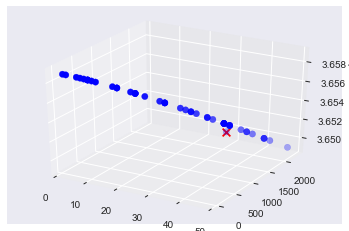

In [80]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

# Plot our data with kernel mapping
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = data_with_kernel[:, 2]      # kernel mapping
xdata = data_with_kernel[:, 0]
ydata = data_with_kernel[:, 1]
ax.scatter3D(xdata, ydata, zdata, s=40, color='b', marker='o')

# Mark the error point 
zerror = np.array(data_with_kernel[2, 2] )     # kernel mapping
xerror = np.array(data_with_kernel[2, 0])
yerror = np.array(data_with_kernel[2, 1])
ax.scatter3D(xerror, yerror, zerror, s=60, color='r', marker='x')



From the plot we can see, normal data points seem to reveal a linear relationship whereas our error point is slightly out of the line. In this case, clearly, clustering wouldn't work since data points do not lie in a cluster. We might need to try linear regression now.  

In [95]:
from sklearn import linear_model


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
x_train = np.column_stack((xdata, ydata))
y_train = zdata
regr.fit(x_train, y_train)

# Now, make a prediction on the same data set
prediction = regr.predict(x_train)
# compute prediction errors
pred_error = abs(prediction - y_train)
print(pred_error)


[3.87769311e-14 8.17721531e-15 1.31560415e-13 1.81529747e-14
 5.79986413e-14 4.51259955e-14 4.63959959e-14 3.06667686e-14
 1.30826538e-14 1.77441380e-14 6.17278899e-14 3.30173725e-14
 3.76759019e-14 3.87769311e-14 3.87769311e-14 3.87769311e-14
 3.34133795e-14 3.87769311e-14 1.90201739e-14 3.30601115e-15
 8.92714042e-14 1.97211547e-13 1.22619152e-15 2.75703469e-14
 3.55617940e-14 3.87769311e-14 3.87765624e-14 3.26489609e-14
 8.06806717e-16 3.26489609e-14 6.17278899e-14 4.52006517e-14
 3.26489609e-14 3.76759019e-14 2.65517074e-14 8.17721531e-15
 8.06806717e-16 4.52677511e-14 8.17721531e-15 3.06667686e-14
 8.19679733e-15 2.65517074e-14 2.65517074e-14 6.17278899e-14
 4.51259955e-14 4.48071557e-14 3.26489609e-14 4.52006517e-14
 4.13693710e-14 3.06667686e-14]


From this we can see at index 2 the value is remarkably different from others, which means using a linear model to fit the data, then calculate prediction errors on the same dataset might be working in this case.